In [1]:
# using CuArrays # comment me out if you don't want to use GPU
using Flux, Flows
import Distributions: rand, logpdf
import PyPlot; const plt = PyPlot
using Tracker: update!

## Generate some data from a mixture of two Gaussians to use

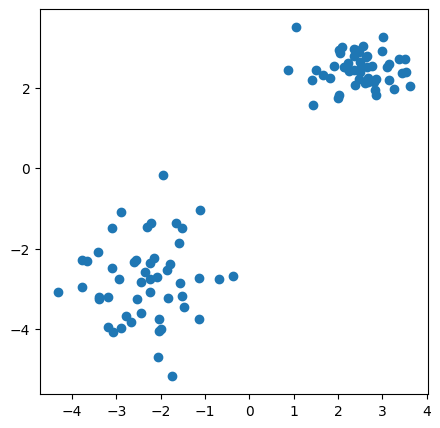

2×100 Array{Float32,2}:
 3.54018  0.863364  2.48866  2.64293  …  -3.78286  -2.2298   -1.12729
 2.40942  2.44353   2.4758   2.7614      -2.96977  -3.09246  -2.73   

In [2]:
X = randn(Float32, 2, 100)
X[:,1:50] .*= 0.5
X[:,1:50] .+= 5.0
X .-= 2.5

plt.figure(figsize=(5, 5))
plt.scatter(X[1,:], X[2,:])

# Send data to GPU
X = X |> gpu

## Create a normalising flow by stacking multiple affine coupling layers

$$ f = f_1 \circ f_2 \circ \cdots \circ f_{N-1} \circ f_N : \mathcal{Z} \rightarrow \mathcal{X}$$

We assume base distribution is the unit Gaussian, i.e. $p_{\mathcal{Z}} = \mathcal{N}(0,1)$.

In [10]:
# Define a base distribution that is easy to work with GPU
struct MvNormal01
    dim::Int
end

# The constant below is a hack to make things work on GPU.
const LOG2PI32 = log(2Float32(pi))
logpdf(d::MvNormal01, x) = sum(-(LOG2PI32 .+ x .* x) ./ 2; dims=1)
rand(d::MvNormal01, n::Int=1) = randn(Float32, d.dim, n) |> gpu

# Make a helper function to composing multiple transformations
function stack_affinecouplings(xdim, ntrans; nhiddens=1, hdim=xdim, actfunc=relu)
    ts = []
    mask = instantiate(AlternatingMasking(xdim)) |> gpu
    for _ in 1:ntrans
        f1 = Dense(xdim, hdim, actfunc) |> gpu
        f21 = Dense(hdim, xdim) |> gpu
        f22 = Dense(hdim, xdim) |> gpu
        t = AffineCoupling(Chain(f1, f21), Chain(f1, f22), mask)
        push!(ts, t)
        mask = 1 .- mask
    end
    return compose(ts...)
end

NLAYERS = 4
H = 20
T = stack_affinecouplings(size(X, 1), NLAYERS; hdim=H)
base = MvNormal01(size(X, 1))

# A normalising flow is nothing but a transformation plus a base distribution
flow = Flow(T, base)

opt = ADAM(1e-3)
ps = params(flow)
;

## Define loss

$$\mathcal{L} = -\log p_{\mathcal{X}}(x) = -\log p_{\mathcal{Z}}(f^{-1}(x)) + \log \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|,$$

where $f^{-1}: \mathcal{X} \rightarrow \mathcal{Z}$.

In [11]:
function compute_loss(x)
    # Get the inverse transformation
    it = inv(flow.t)
    # Do f inverse
    z, logdet = it(x)
    # Compute log-density
    logdensity = logpdf(flow, z) + logdet
    return -sum(logdensity) / size(x, 2)
end

compute_loss (generic function with 1 method)

## Run optimisation

In [12]:
niters = 2_000

for iter = 1:niters
    print("."); if iter % 100 == 0 println("($iter/$niters) done") end
    loss = compute_loss(X)
    gs = Tracker.gradient(() -> loss, ps)
    update!(opt, ps, gs)
end

....................................................................................................(100/2000) done
....................................................................................................(200/2000) done
....................................................................................................(300/2000) done
....................................................................................................(400/2000) done
....................................................................................................(500/2000) done
....................................................................................................(600/2000) done
....................................................................................................(700/2000) done
....................................................................................................(800/2000) done
........................................................................

## Draw samples

$$ z \sim \mathcal{N}(0,1) $$
$$ x = f(z) $$

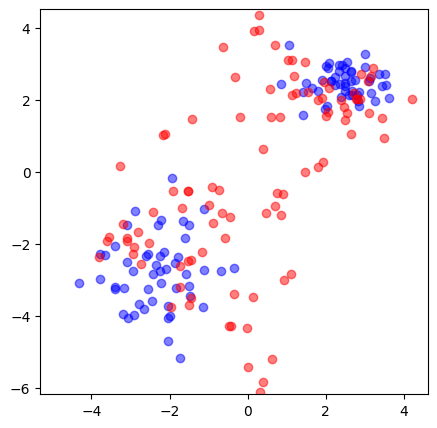

(-6.188000202178955, 4.5166215896606445)

In [13]:
# Draw 100 samples from the normalising flow
Xgen = rand(flow, 100) |> cpu |> Flux.data

plt.figure(figsize=(5,5))
plt.scatter(X[1,:], X[2,:], c="blue", alpha=0.5, label="data")
plt.scatter(Xgen[1,:], Xgen[2,:], c="red", alpha=0.5, label="samples")
plt.xlim([extrema(X[1,:])...] + [-1, 1])
plt.ylim([extrema(X[2,:])...] + [-1, 1])